In [1]:
!pip show PyEMD
import sys
!{sys.executable} -m pip install PyEMD
!pip show PyEMD
from PyEMD import EMD
print(dir(EMD))  # lista de funciones, clases, etc.
help(EMD)        # documentación si está bien escrita

Name: pyemd
Version: None
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages
Requires: 
Required-by: 
Name: pyemd
Version: None
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages
Requires: 
Required-by: 
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_extrema_parabol', '_find_extrema_simple', '_normalize_time', '_not_duplicate', 'check_imf', 'emd', 'end_condition', 'extract_max_min_spline', 'find_extrema', 'get_imfs_and_residue', 'get_imfs_and_trend', 'l

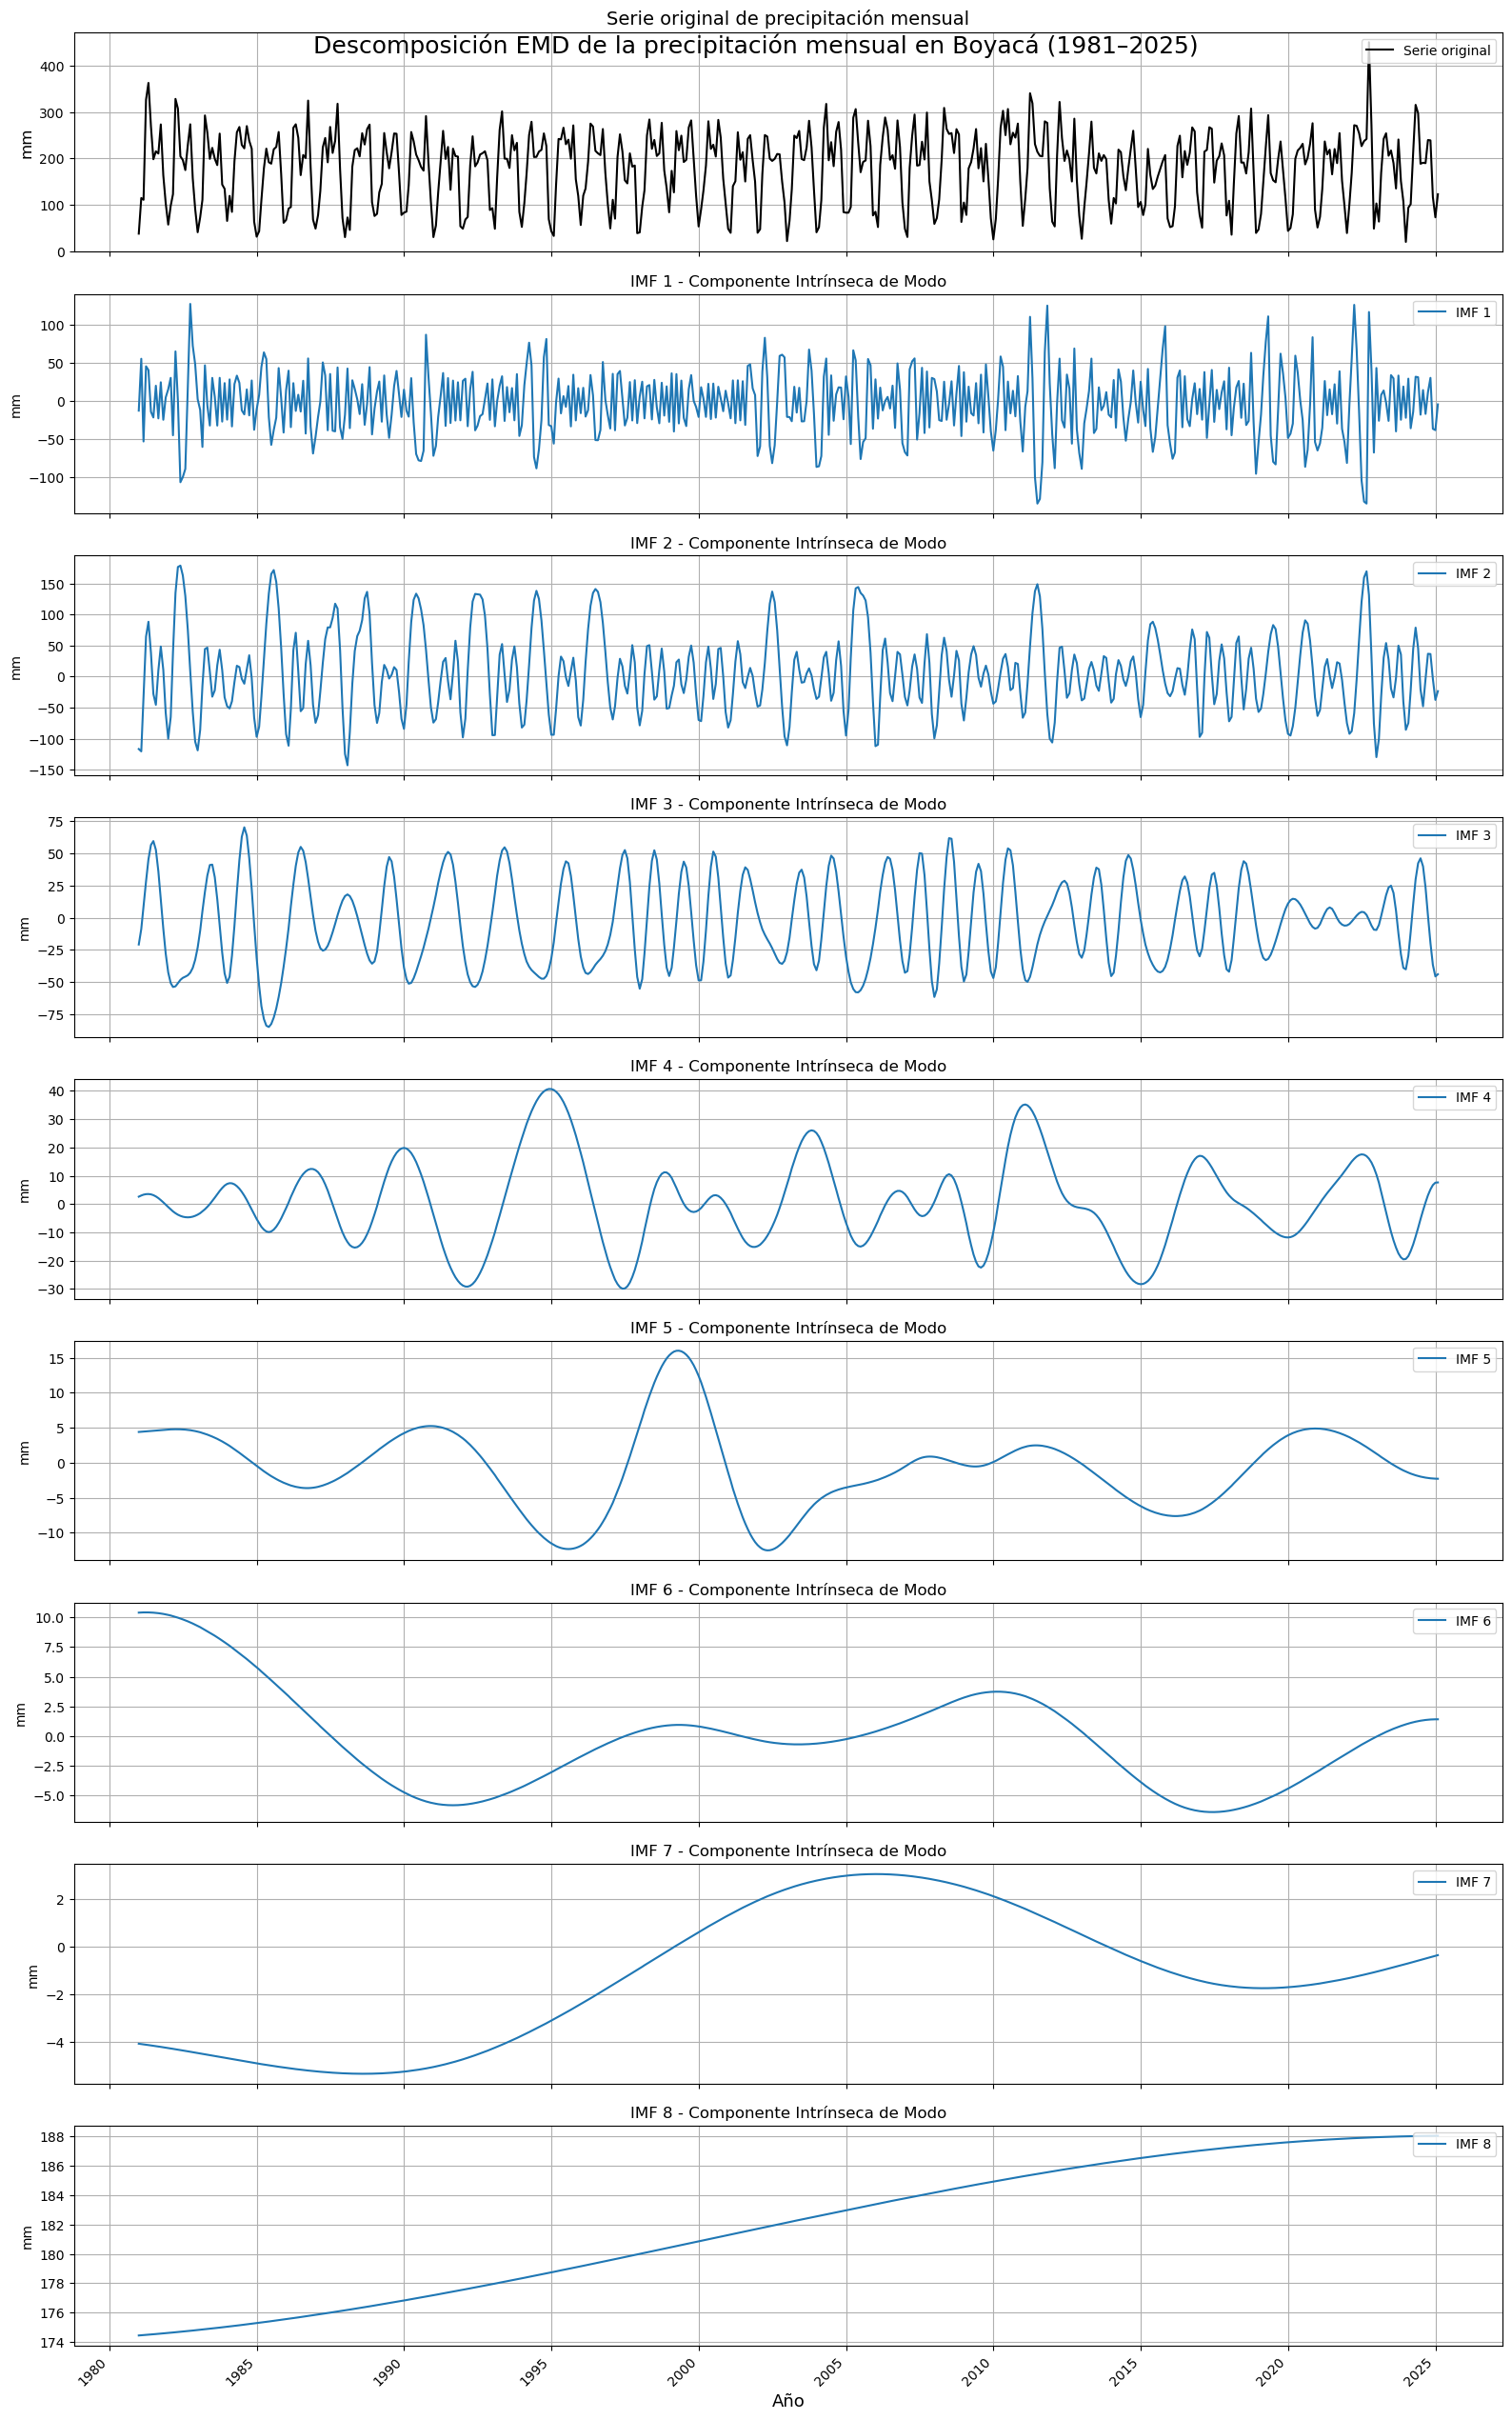

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 📂 Cargar dataset
ds = xr.open_dataset("/Users/riperez/Conda/anaconda3/doc/precipitation/output/boyaca_region_monthly_sum.nc")
precip = ds["total_precipitation"]
df = precip.to_dataframe().reset_index()
df["date"] = pd.to_datetime(df["time"])
df_monthly = df.groupby("date")["total_precipitation"].mean().interpolate()

# 🧠 Descomposición EMD
signal = df_monthly.values
emd = EMD()
imfs = emd.emd(signal)

# 🔢 Obtener rango de años
start_year = df_monthly.index.min().year
end_year = df_monthly.index.max().year

# 🎨 Graficar EMD
fig, axes = plt.subplots(imfs.shape[0] + 1, 1, figsize=(16, 3 * (imfs.shape[0] + 1)), sharex=True)
fig.suptitle(f"Descomposición EMD de la precipitación mensual en Boyacá ({start_year}–{end_year})", fontsize=18, y=0.93)

# Serie original
axes[0].plot(df_monthly.index, signal, color='black', label="Serie original")
axes[0].set_ylabel("mm", fontsize=12)
axes[0].set_title("Serie original de precipitación mensual", fontsize=14)
axes[0].legend(loc="upper right")
axes[0].grid(True)

# IMFs
for i in range(imfs.shape[0]):
    axes[i+1].plot(df_monthly.index, imfs[i], label=f"IMF {i+1}")
    axes[i+1].set_title(f"IMF {i+1} - Componente Intrínseca de Modo", fontsize=12)
    axes[i+1].set_ylabel("mm", fontsize=10)
    axes[i+1].grid(True)
    axes[i+1].legend(loc="upper right")

# ⏳ Eje de fechas legible
axes[-1].xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.xlabel("Año", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
